<a href="https://colab.research.google.com/github/spatank/machine_learning_playground/blob/main/classification_and_color_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Colab 2: Gettin classy**

In this colab we'll download image classification datasets and train convolutional network classifiers.  As a fun little diversion, we'll learn a color space compressor by building one right into the classification network. 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow_datasets as tfds
import scipy.ndimage as nim

tfkl = tf.keras.layers

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tf.config.list_physical_devices()

# Part 1: Learning to tell the difference between a boat and a frog

In [ ]:
# There are a ton of available datasets listed here: https://www.tensorflow.org/datasets/catalog/overview
# We'll start with a classic one, CIFAR10, which has very small images (32x32) and only 10 classes of objects
dset_train, info = tfds.load('cifar10', split='train[:90%]', with_info=True, as_supervised=True)
dset_val = tfds.load('cifar10', split='train[-10%:]', as_supervised=True)
dset_test = tfds.load('cifar10', split='test', as_supervised=True)
print(info)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteTPAADY/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteTPAADY/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    

In [ ]:
# The dataset itself is more of a factory than a dataset at the moment
# It's an iterable, and ready to start spitting out image-label pairs, but on its own it's just the following:
print(dset_train)

<PrefetchDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>


In [ ]:
# Each pixel is an int between 0 and 255, but we'd rather have it be a float between 0 and 1
dset_train = dset_train.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label))
dset_val = dset_val.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label))
dset_test = dset_test.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label))

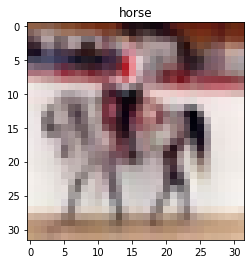

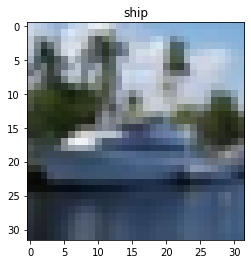

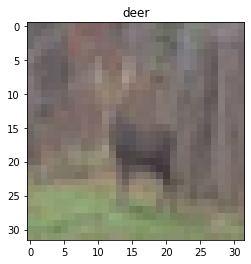

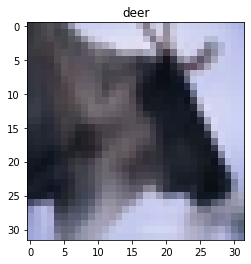

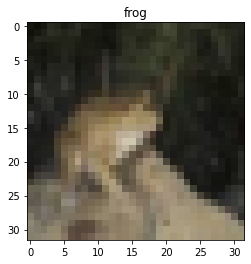

In [ ]:
# Display some examples
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for image, label in dset_train.take(5):
  plt.imshow(image)
  plt.title(cifar10_classes[label.numpy()])
  plt.show()

In [ ]:
# Those pics aren't much to look at, but we can still train a decent classifier off them
# Let's build a classifier network out of convolutional layers

# More parameters are needed to specify a convolutional layer than the dense layers we used in the last colab
# First there's the number of different filters (which is also the output dimensionality for the layer)
# Then there's the side length size each filter, something like 3 or 5
# As before, we want nonlinearity in each layer; ReLU is good for classification
# Another important parameter is the strides per layer, which reduces the 
# dimension of the output array by the stride factor (default is 1)

# Let's make a conv layer and pass a dummy input through it
single_conv_layer = tfkl.Conv2D(10, 3, activation='relu', strides=1)

input_tensor = tf.ones((1, 32, 32, 3))
output_tensor = single_conv_layer(input_tensor)

# TODO: Make a single conv layer whose output will be 13x13x17 when the input is 32x32x3
print(output_tensor.shape)

(1, 30, 30, 10)


In [ ]:
# Build the network 
input_shape = (32, 32, 3)
num_classes = 10

layers = [tfkl.Input(input_shape)]

# TODO: add 4 conv layers of size [32, 64, 128, 256], kernel size 3, relu activation, and stride of 2 for layer 2 and 4

layers += []

# The output of the last conv layer will be a smaller 2D array, and we need to flatten that to get toward a final prediction (which is just a flat vector)
layers += [tfkl.Flatten()]

# Now we can just process that into our prediction, a vector of 10 probabilities, one for each class
# 'softmax' activation yields normalized probabilities
layers += [tfkl.Dense(num_classes, activation='softmax')]

classification_model = tf.keras.Sequential(layers)

print(classification_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                64010     
Total params: 452,426
Trainable params: 452,426
Non-trainable params: 0
__________________________________________________

In [ ]:
# As before, let's use the built in keras model.compile and model.fit to train this classifier
# Now we use a cross entropy loss, though, because we are comparing probability distributions
# The sparse part is just because the ground truth is known to be a one-hot vector (all 0s and one 1)
classification_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

batch_size = 256
training_history = classification_model.fit(dset_train.shuffle(1000).batch(batch_size), epochs=2, validation_data=dset_val.batch(batch_size))

Epoch 1/2
176/176 [==============================] - 180s 1s/step - loss: 1.6226 - accuracy: 0.4137 - val_loss: 1.3866 - val_accuracy: 0.4948
Epoch 2/2
176/176 [==============================] - 174s 989ms/step - loss: 1.3035 - accuracy: 0.5358 - val_loss: 1.2235 - val_accuracy: 0.5628


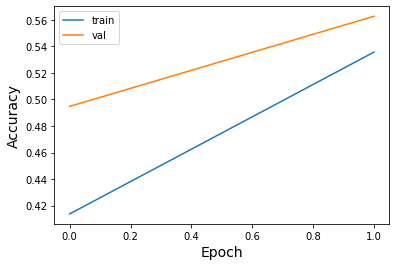

In [ ]:
# Let's look at the accuracy over time 
training_accuracy = training_history.history['accuracy']
val_accuracy = training_history.history['val_accuracy']
plt.plot(training_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.show()

In [ ]:
# And now the test set accuracy
classification_model.evaluate(dset_test.batch(batch_size))

40/40 [==============================] - 10s 253ms/step - loss: 1.2219 - accuracy: 0.5645


[1.2218910455703735, 0.5644999742507935]

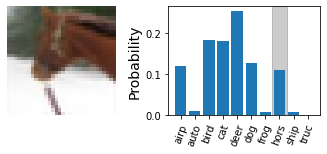

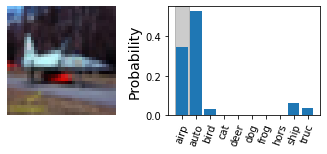

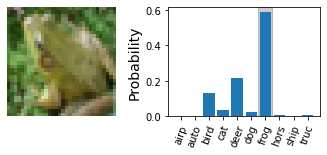

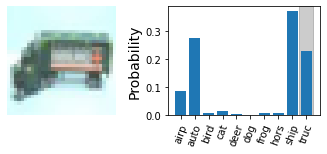

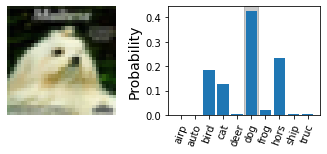

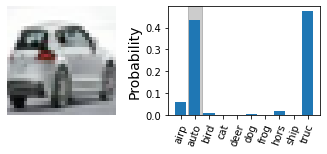

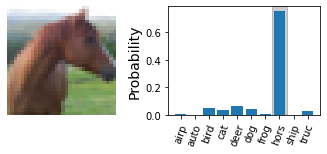

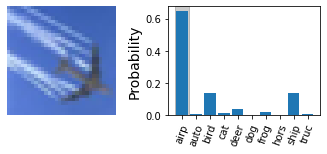

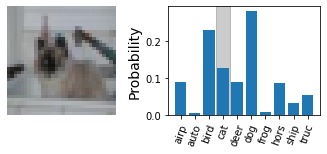

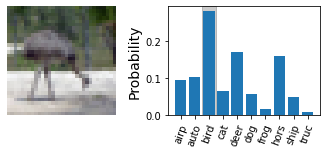

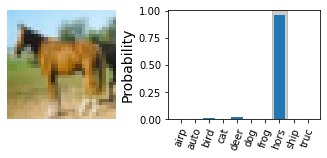

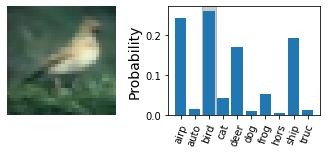

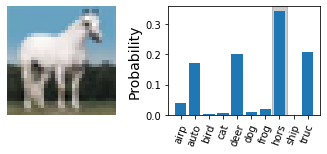

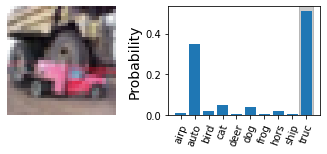

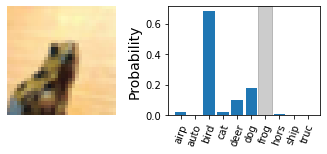

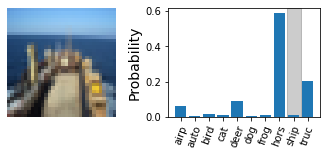

In [ ]:
# Display some images with their predictions
test_images, test_labels = next(iter(dset_test.batch(16)))
test_predictions = classification_model(test_images)
for i in range(16):
  plt.figure(figsize=(6, 2))
  plt.subplot(121)
  plt.imshow(test_images[i])
  plt.axis('off')
  plt.subplot(122)
  plt.axvspan(test_labels[i].numpy()-0.5, test_labels[i].numpy()+0.5, alpha=0.2, color='k')
  plt.bar(range(num_classes), test_predictions[i])
  plt.ylabel('Probability', fontsize=14)
  plt.xticks(range(10), [class_label[:4] for class_label in cifar10_classes], rotation=70)
  plt.show()

In [ ]:
# Ok, that was probably painfully slow if you used the default runtime.
# Change to a GPU by going to Runtime -> Change runtime type -> GPU
# Now you can train 10-20 epochs instead of 2

**Challenge**: Get the best test set accuracy with under a million trainable parameters.  
Tips: Change the layer specs, add a batch normalization layer, change the flatten to a pooling layer and throw a dense layer before the final classification output.  Add an image augmentation or two to the data by using dataset.map(fn) (e.g. tf.image.random_flip_left_right())

# Part 2: Color space compression

We're going to use this simple framework to automatically compress RGB space to a single color channel

The beauty of it is we can just throw a color space converter (3D->1D) into the model and let the gradients work themselves out

In [ ]:
# Pick your favorite matplotlib colormap to display the 1D color channel
# (https://matplotlib.org/stable/tutorials/colors/colormaps.html)
single_channel_cmap = 'cividis'

In [ ]:
# Very similarly to last week's colab, we want a mapping from a low-dimensional
# input space (RGB) to a low-dimensional output space (1D learned color space)
# Instead of dense layers, we define it through convolutions operating on only a
# single pixel, blowing it up to a few hundred intermediate dimensions before 
# reducing to 1D, and forcing the output to be between 0 and 1 with sigmoid activation

# Initializing the weights as before helps with training; otherwise the starting
# color space may pass too little information on to the rest of the network for 
# training to be successful
kernel_std = 0.4
rgb_converter = tf.keras.Sequential([tfkl.Conv2D(128, 1, activation='tanh', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=kernel_std)),
                                     tfkl.Conv2D(128, 1, activation='tanh', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=kernel_std)),
                                     tfkl.Conv2D(128, 1, activation='tanh', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=kernel_std)),
                                     tfkl.Conv2D(1, 1, activation='sigmoid'),
                                     ])

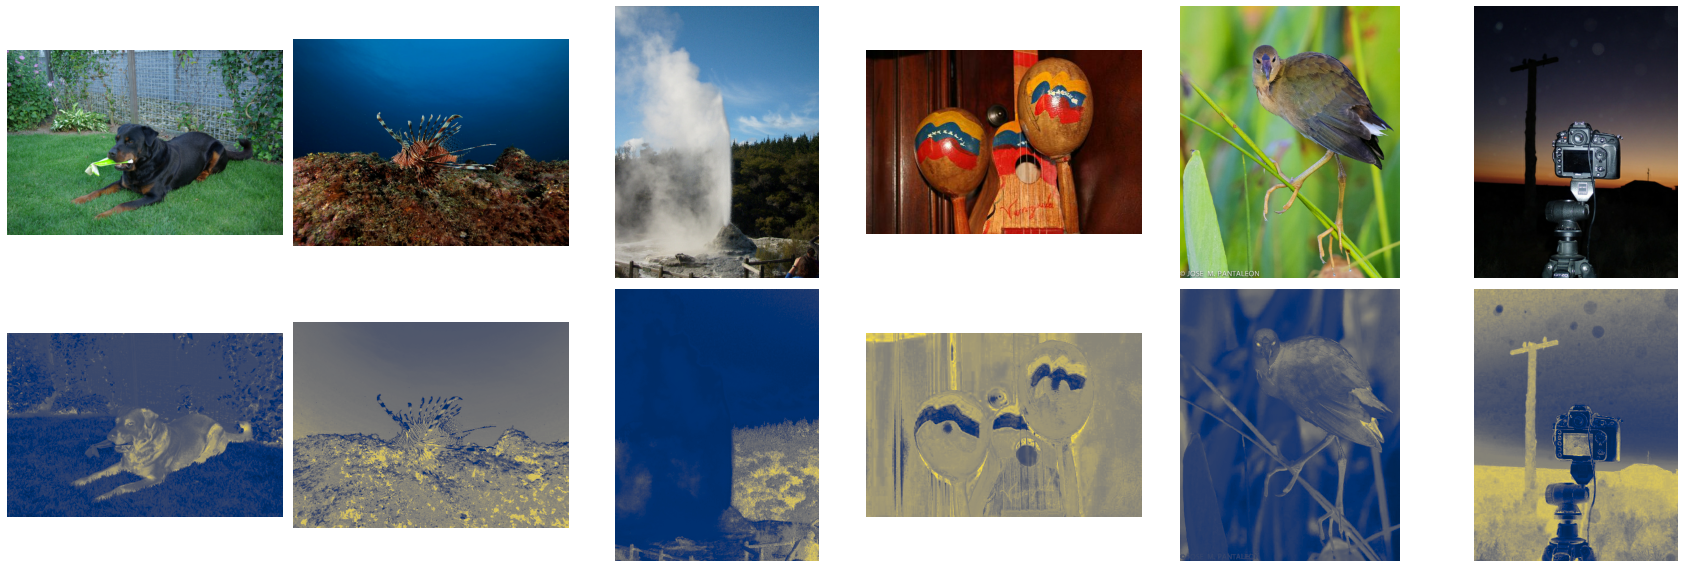

In [ ]:
# To visualize the color space, let's get some larger, more interesting pics to 
# see how the color converter changes them
sample_dset = tfds.load('imagenet_v2', split='test', as_supervised=True)
sample_dset = sample_dset.map(lambda image, _: tf.image.convert_image_dtype(image, tf.float32))

# Grab a couple of pics with decent color ranges
curated_image_inds = [2, 3, 10, 35, 42, 54]
sample_images = []
for image_ind, image in enumerate(sample_dset.take(75)):
  if image_ind in curated_image_inds:
    sample_images.append(image)

def display_sample_converted_images(sample_images, rgb_converter):
  plt.figure(figsize=(24, 8))
  for plot_ind, image in enumerate(sample_images):
    plt.subplot(2, len(sample_images), plot_ind+1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(2, len(sample_images), plot_ind+len(sample_images)+1)
    plt.imshow(rgb_converter(image[tf.newaxis])[0, ..., 0], cmap=single_channel_cmap)
    plt.axis('off')
  plt.tight_layout()
  plt.show()
  return

display_sample_converted_images(sample_images, rgb_converter)

We're also going to display the actual color space, with the full color space above the learned one


In [ ]:
#@title Fn to display the color space using slices through a cone, w hue=azimuth, radius=chroma (~saturation), and height=value
def rgb_to_hue_chroma_value(r, g, b, circle=True):
  maxx = np.max(np.stack([r, g, b], -1), axis=-1)
  minn = np.min(np.stack([r, g, b], -1), axis=-1)
  alpha = 0.5 * (2*r - g - b)
  beta = np.sqrt(3) / 2 * (g - b)
  hue = np.arctan2(beta, alpha)
  value = maxx
  if circle:
    chroma = maxx - minn
  else: 
    chroma = np.hypot(alpha, beta)
  return hue, chroma, value

def display_color_space(converter, display_raw=True, cmap='cividis', rgb_steps=30,
                        num_val_steps=8):
  rs, gs, bs = np.meshgrid(np.linspace(0, 1, rgb_steps),
                          np.linspace(0, 1, rgb_steps),
                          np.linspace(0, 1, rgb_steps))
  rs = rs.reshape([-1])
  gs = gs.reshape([-1])
  bs = bs.reshape([-1])
  cols = np.stack([rs, gs, bs], -1)
  hues, chromas, values = rgb_to_hue_chroma_value(rs, gs, bs)
  eps = 1e-6
  value_bins = np.linspace(0, 1+eps, num_val_steps)
  bin_inds = np.digitize(values, value_bins)
  if display_raw:
    plt.figure(figsize=((num_val_steps-1)*4, 4))
    for i in range(1, num_val_steps):
      disp_inds = np.where(bin_inds == i)
      plt.subplot(1, num_val_steps-1, i, aspect='equal')
      plt.scatter(chromas[disp_inds]*np.cos(hues[disp_inds]), chromas[disp_inds]*np.sin(hues[disp_inds]), c=cols[disp_inds])
      plt.axis('off')
      plt.xlim(-1.1, 1.1)
      plt.ylim(-1.1, 1.1)
    plt.show()

  converted_cols = np.float32(rgb_converter(cols[tf.newaxis, tf.newaxis])[0, 0, :, 0])
  hues, chromas, values = rgb_to_hue_chroma_value(rs, gs, bs)
  eps = 1e-6
  value_bins = np.linspace(0, 1+eps, num_val_steps)
  bin_inds = np.digitize(values, value_bins)
  plt.figure(figsize=((num_val_steps-1)*4, 4))
  for i in range(1, num_val_steps):
    disp_inds = np.where(bin_inds == i)
    plt.subplot(1, num_val_steps-1, i, aspect='equal')
    plt.scatter(chromas[disp_inds]*np.cos(hues[disp_inds]), chromas[disp_inds]*np.sin(hues[disp_inds]), c=converted_cols[disp_inds], cmap=single_channel_cmap)
    plt.axis('off')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
  plt.show()
  return

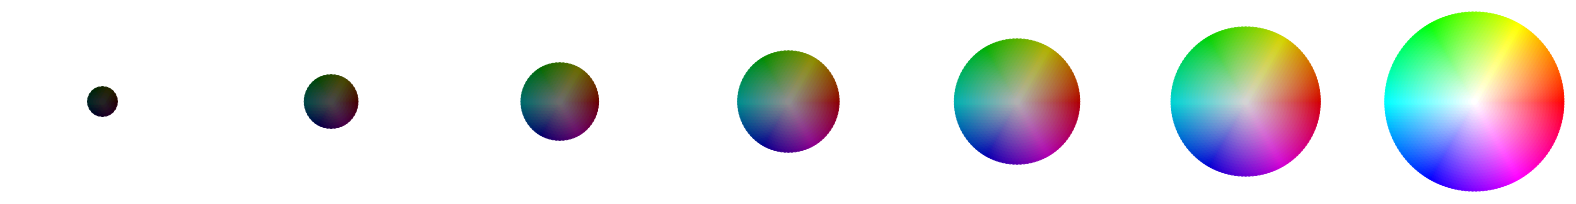

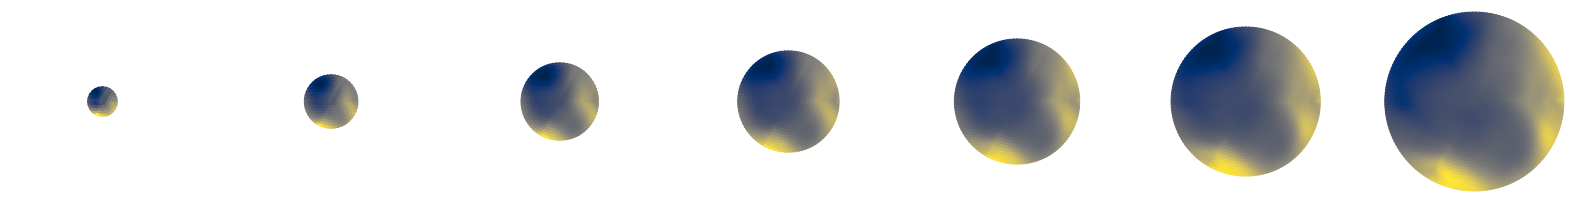

In [ ]:
display_color_space(rgb_converter)

In [ ]:
classification_model = tf.keras.Sequential([
                                            tfkl.Input((32, 32, 3)),
                                            rgb_converter,
                                            # TODO: Fill in several conv layers here
                                            tfkl.GlobalAveragePooling2D(),
                                            tfkl.Dense(256, 'relu'),
                                            tfkl.Dense(10, 'softmax'),
                                            ])
print(classification_model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, None, None, 1)     33665     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 64)        102464    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 3, 3, 256)         295168    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

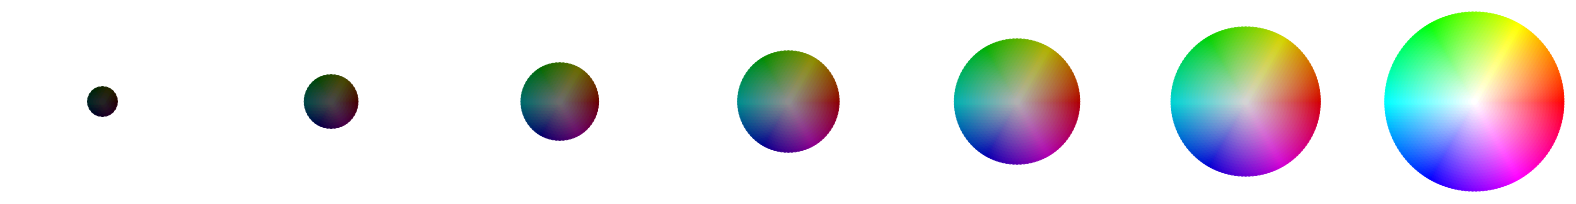

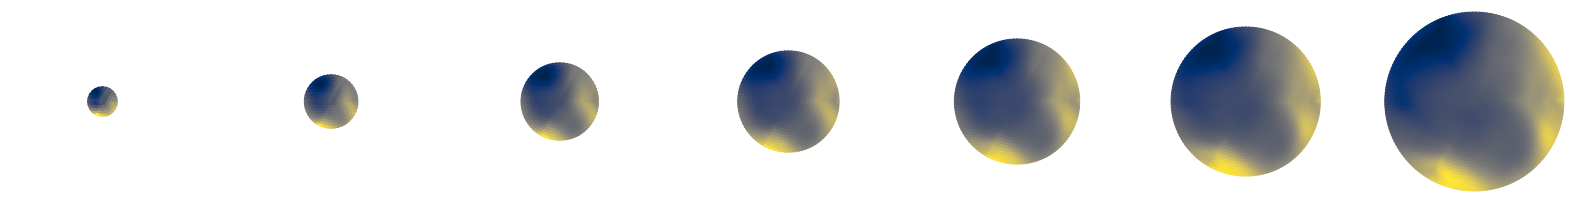

Epoch 1/5
106/106 [==============================] - 11s 96ms/step - loss: 1.8162 - accuracy: 0.1764 - val_loss: 1.7375 - val_accuracy: 0.2548
Epoch 2/5
106/106 [==============================] - 9s 88ms/step - loss: 1.6467 - accuracy: 0.3048 - val_loss: 1.5969 - val_accuracy: 0.3393
Epoch 3/5
106/106 [==============================] - 10s 89ms/step - loss: 1.5846 - accuracy: 0.3470 - val_loss: 1.5553 - val_accuracy: 0.3502
Epoch 4/5
106/106 [==============================] - 10s 89ms/step - loss: 1.5482 - accuracy: 0.3664 - val_loss: 1.5333 - val_accuracy: 0.3824
Epoch 5/5
106/106 [==============================] - 10s 90ms/step - loss: 1.5015 - accuracy: 0.3891 - val_loss: 1.4619 - val_accuracy: 0.4062


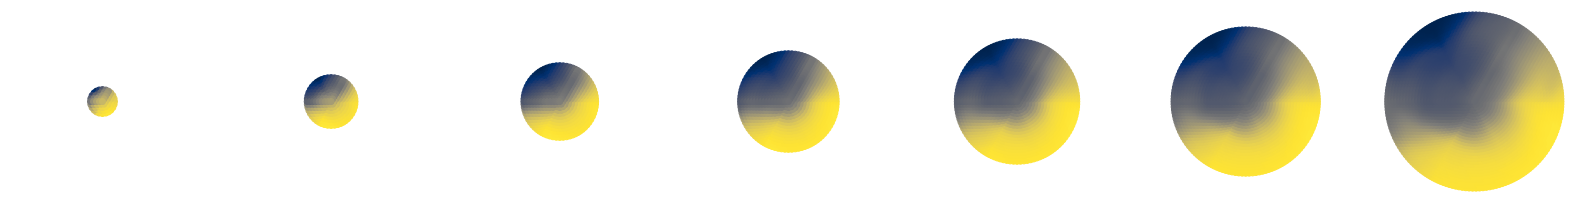

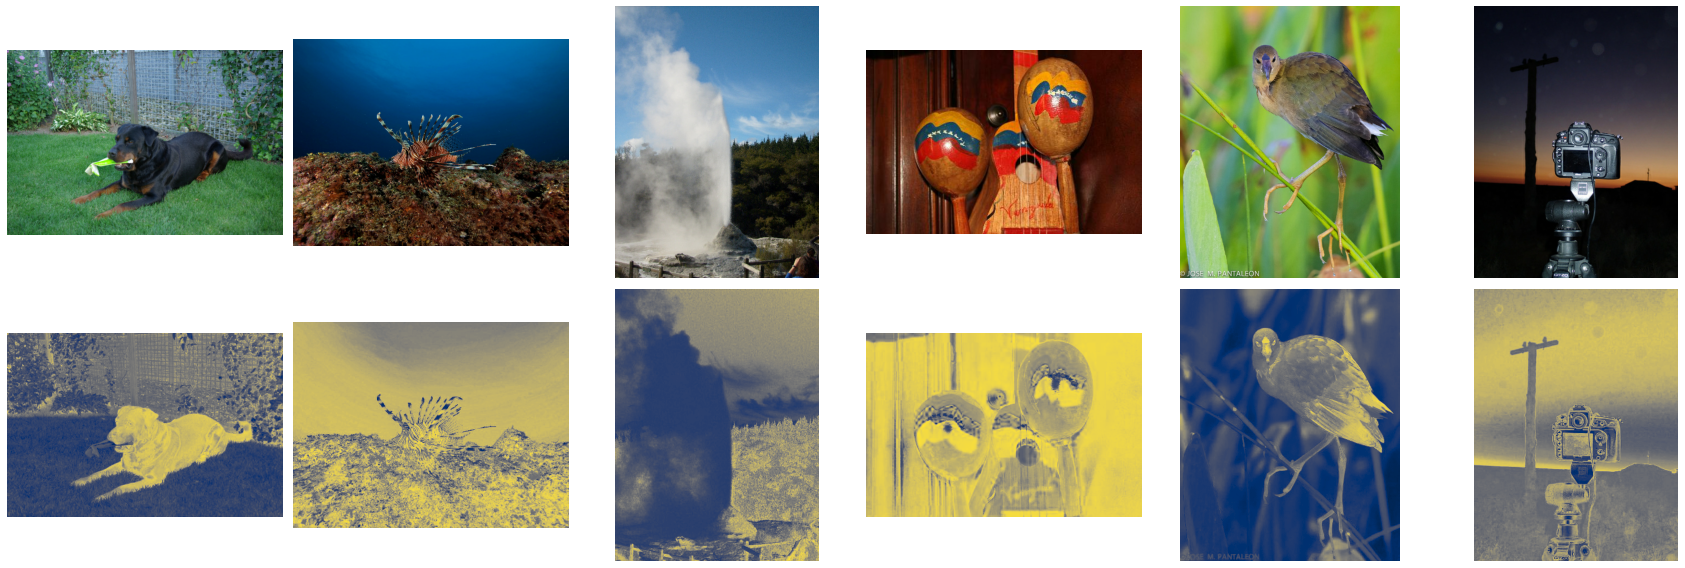

Epoch 1/5
106/106 [==============================] - 10s 95ms/step - loss: 1.4388 - accuracy: 0.4200 - val_loss: 1.4153 - val_accuracy: 0.4418
Epoch 2/5
106/106 [==============================] - 10s 94ms/step - loss: 1.3777 - accuracy: 0.4518 - val_loss: 1.4086 - val_accuracy: 0.4384
Epoch 3/5
106/106 [==============================] - 10s 96ms/step - loss: 1.3322 - accuracy: 0.4771 - val_loss: 1.3294 - val_accuracy: 0.4693
Epoch 4/5
106/106 [==============================] - 10s 95ms/step - loss: 1.2927 - accuracy: 0.4931 - val_loss: 1.2929 - val_accuracy: 0.4917
Epoch 5/5
106/106 [==============================] - 10s 94ms/step - loss: 1.2599 - accuracy: 0.5098 - val_loss: 1.2656 - val_accuracy: 0.4944


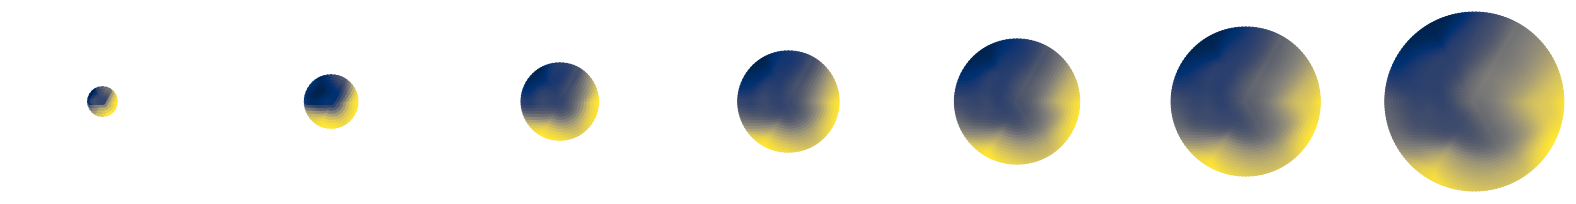

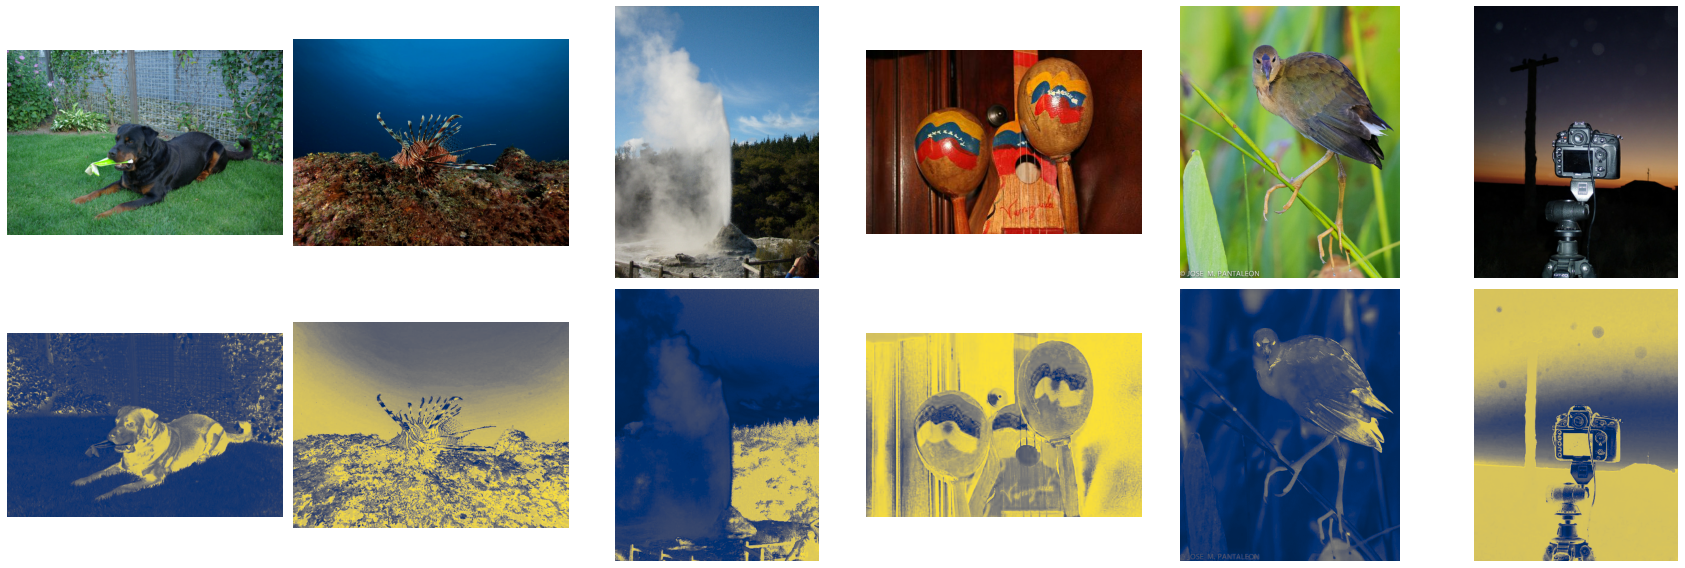

Epoch 1/5
106/106 [==============================] - 10s 95ms/step - loss: 1.2401 - accuracy: 0.5145 - val_loss: 1.2715 - val_accuracy: 0.4947
Epoch 2/5
106/106 [==============================] - 10s 96ms/step - loss: 1.2032 - accuracy: 0.5305 - val_loss: 1.2410 - val_accuracy: 0.5158
Epoch 3/5
106/106 [==============================] - 10s 97ms/step - loss: 1.1777 - accuracy: 0.5449 - val_loss: 1.2329 - val_accuracy: 0.5110
Epoch 4/5
106/106 [==============================] - 10s 98ms/step - loss: 1.1509 - accuracy: 0.5533 - val_loss: 1.3198 - val_accuracy: 0.4686
Epoch 5/5
106/106 [==============================] - 10s 93ms/step - loss: 1.1382 - accuracy: 0.5599 - val_loss: 1.2039 - val_accuracy: 0.5300


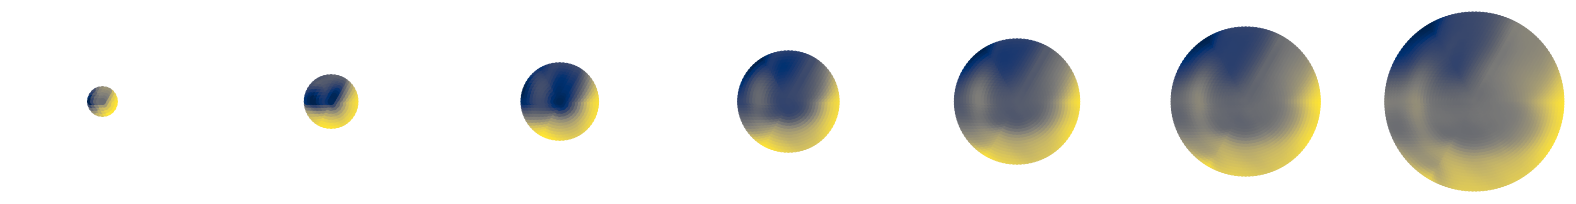

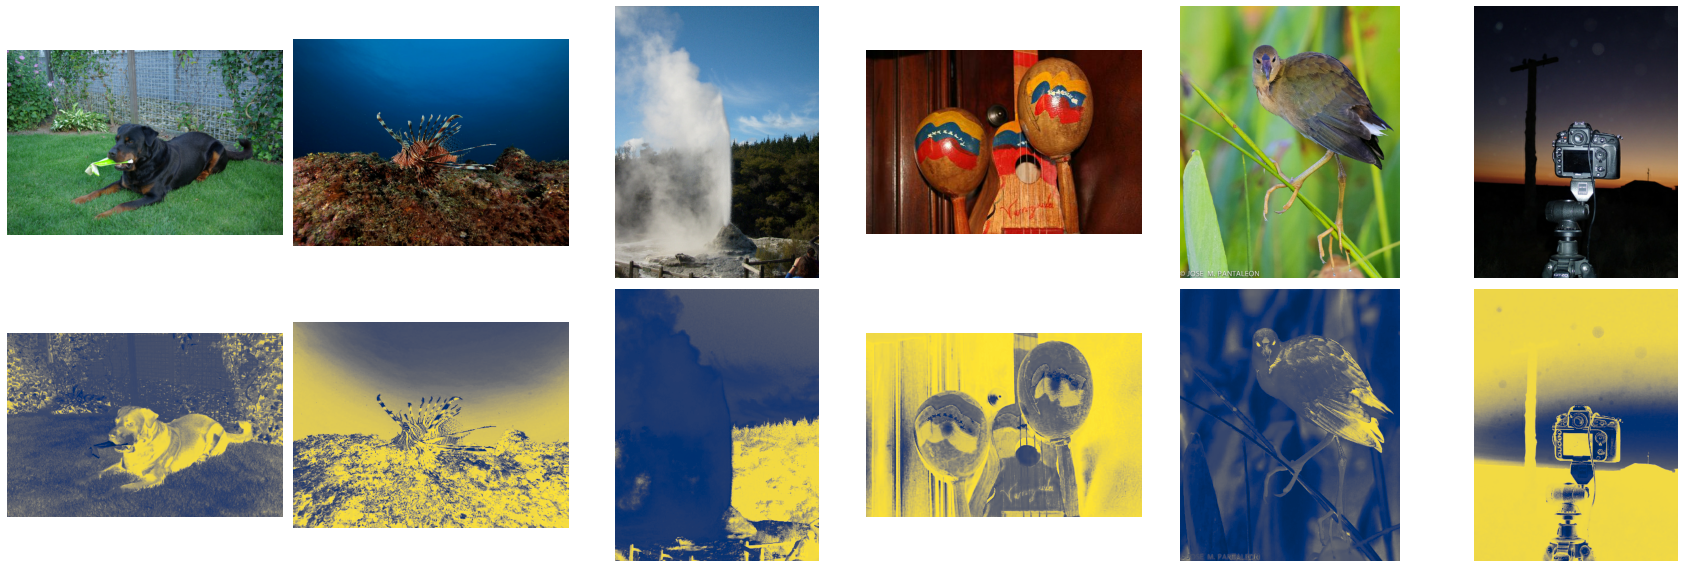

Epoch 1/5
106/106 [==============================] - 10s 97ms/step - loss: 1.1071 - accuracy: 0.5744 - val_loss: 1.1865 - val_accuracy: 0.5361
Epoch 2/5
106/106 [==============================] - 11s 99ms/step - loss: 1.0759 - accuracy: 0.5858 - val_loss: 1.1908 - val_accuracy: 0.5378
Epoch 3/5
106/106 [==============================] - 10s 98ms/step - loss: 1.0475 - accuracy: 0.5997 - val_loss: 1.1697 - val_accuracy: 0.5416
Epoch 4/5
106/106 [==============================] - 10s 96ms/step - loss: 1.0223 - accuracy: 0.6098 - val_loss: 1.2062 - val_accuracy: 0.5358
Epoch 5/5
106/106 [==============================] - 10s 96ms/step - loss: 1.0034 - accuracy: 0.6183 - val_loss: 1.1875 - val_accuracy: 0.5490


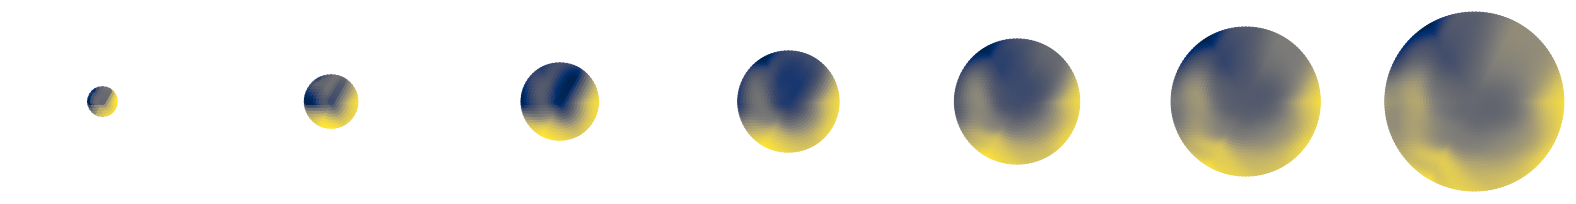

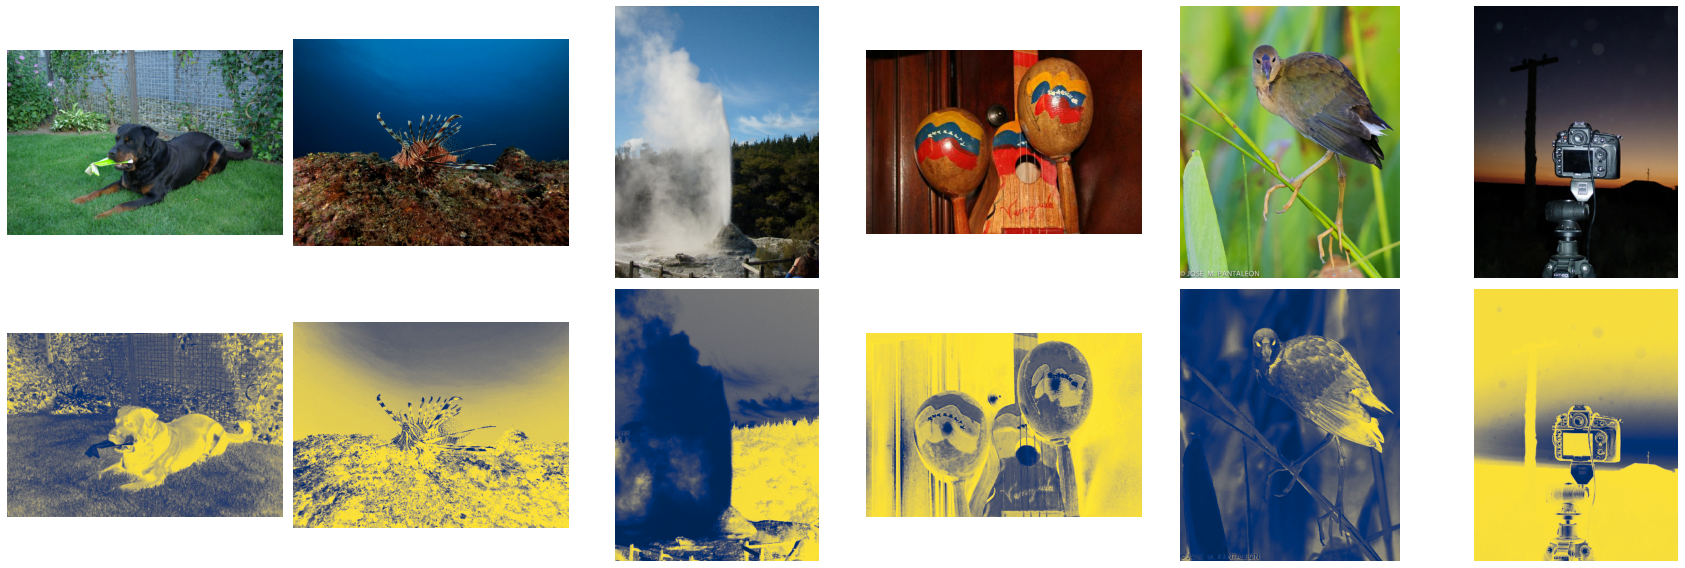

In [ ]:
# We're going to train on a subset of classes to have a little more control over
# what the network should learn to discern

# for reference (from earlier):
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# There are some natural categories -- e.g. the animals, or the machines, or things w blue backgrounds
# Let's try just the animals
classes = [2, 3, 4, 5, 6, 7]

classification_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

batch_size = 256
num_epochs = 20
display_every = 5

dset_train_filtered = dset_train.filter(lambda _, label: tf.reduce_any(tf.equal(label, classes)))
dset_val_filtered = dset_val.filter(lambda _, label: tf.reduce_any(tf.equal(label, classes)))
dset_test_filtered = dset_test.filter(lambda _, label: tf.reduce_any(tf.equal(label, classes)))

display_color_space(rgb_converter, display_raw=True)
for _ in range(0, num_epochs, display_every):
  classification_model.fit(dset_train_filtered.shuffle(1000).batch(batch_size), epochs=display_every, validation_data=dset_val_filtered.batch(batch_size))
  display_color_space(rgb_converter, display_raw=False)
  display_sample_converted_images(sample_images, rgb_converter)

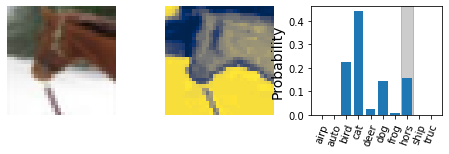

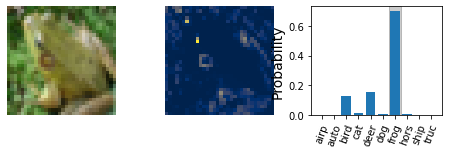

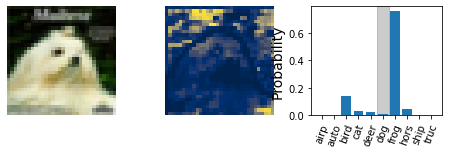

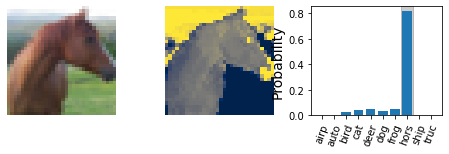

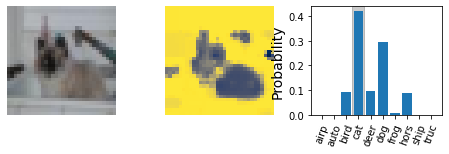

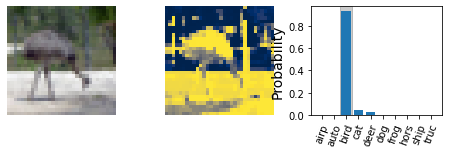

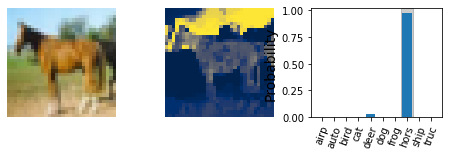

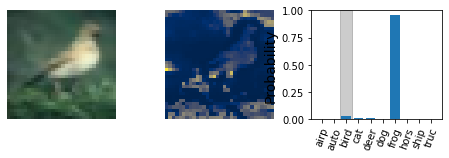

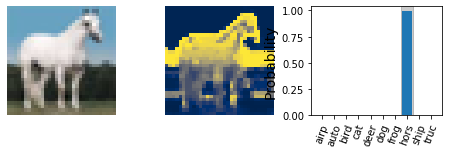

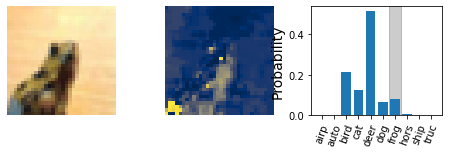

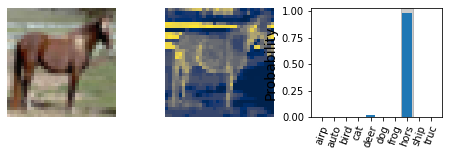

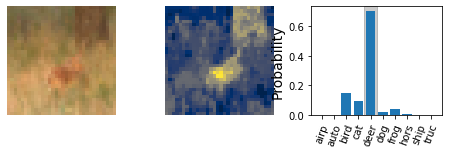

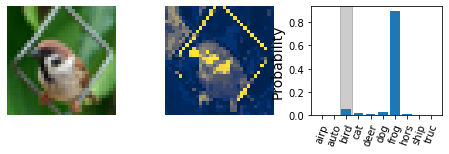

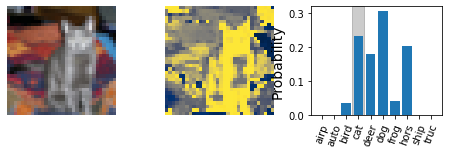

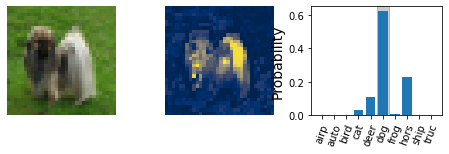

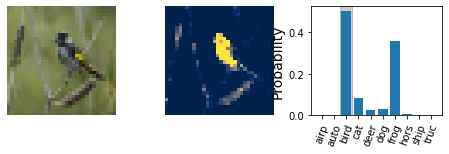

In [ ]:
# Display some images with their predictions
test_images, test_labels = next(iter(dset_test_filtered.batch(16)))
mono_images = rgb_converter(test_images)
test_predictions = classification_model(test_images, training=False)
for i in range(16):
  plt.figure(figsize=(8, 2))
  plt.subplot(131)
  plt.imshow(test_images[i])
  plt.axis('off')
  plt.subplot(132)
  plt.imshow(mono_images[i, ..., 0], cmap=single_channel_cmap)
  plt.axis('off')
  plt.subplot(133)
  plt.axvspan(test_labels[i].numpy()-0.5, test_labels[i].numpy()+0.5, alpha=0.2, color='k')
  plt.bar(range(10), test_predictions[i])
  plt.ylabel('Probability', fontsize=14)
  plt.xticks(range(10), [class_label[:4] for class_label in cifar10_classes], rotation=70)

  plt.show()

**Challenge**: Learn a color space for the cassava dataset, which tries to distinguish between healthy and diseased plants.

In [ ]:
# TODO: Load the dataset
# In addition to the previous preprocessing step of converting pixels to floats,
# Now the images are all different sizes so use tf.image.resize_with_crop_or_pad to convert to size 128x128

In [ ]:
# TODO: Make the color converter and classification network
kernel_std = 0.4
rgb_converter = []

classification_model = [] 
print(classification_model.summary())

In [ ]:
# TODO: Train the model to classify the cassava plants, and visualize the color space

In [ ]:
# Display test images with their predictions
test_images, test_labels = next(iter(dset_val.batch(16)))
mono_images = rgb_converter(test_images)
test_predictions = classification_model(test_images, training=False)
for i in range(16):
  plt.figure(figsize=(8, 2))
  plt.subplot(131)
  plt.imshow(test_images[i])
  plt.axis('off')
  plt.subplot(132)
  plt.imshow(mono_images[i, ..., 0], cmap=single_channel_cmap)
  plt.axis('off')
  plt.subplot(133)
  plt.axvspan(test_labels[i].numpy()-0.5, test_labels[i].numpy()+0.5, alpha=0.2, color='k')
  plt.bar(range(num_classes), test_predictions[i])
  plt.ylabel('Probability', fontsize=14)
  plt.xlabel('Class', fontsize=14)

  plt.show()